# Sprint1
* Search Label STAC API on https://stac-api-dev.terradue.com/ using AOI and datetime (of the label STAC Item)
* filter results using S2 scenes properties (eg: `cloud_cover`, `datetime`)
* disply filtered Label STAC Items results on interactive map
* for the filtered Label STAC Items, load S2 scene 

# Set-up

In [ ]:
import pystac
from pystac_client import Client
from pystac import Link, Asset
from pystac.extensions.label import LabelExtension
from pystac.extensions.label import LabelType
from pystac.extensions.label import LabelClasses
from pystac.extensions.label import LabelStatistics
from pystac.extensions.version import ItemVersionExtension

from shapely.geometry import box, mapping, Polygon
import shapely.wkt

import os
import numpy as np
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import xarray as xr
import stackstac

from helpers import *

In [2]:
# Access to Catalog 
URL = 'https://stac-api-dev.terradue.com/'

headers = []

cat = Client.open(URL, headers=headers)
# cat.set_conforms_to('https://api.stacspec.org/v1.0.0-rc.1/item-search')
cat

<Client id=stac-fastapi>

## Define params


In [34]:
# Collection 
collections=["ai-extensions-svv-dataset-labels"]

# Start and End dates of the item
start_date_str_it = '2023-08-01'; start_date_it = datetime.fromisoformat(start_date_str_it)
stop_date_str_it = '2023-08-15'; stop_date_it = datetime.fromisoformat(stop_date_str_it)

# BBOX or AOI
# bbox = [-74.9211627, 17.818496, -72.2759771, 19.654895]
aoi='POLYGON((-120.90 37.55,-120.32 37.55,-120.32 37.10,-120.90 37.10,-120.90 37.55))'; bbox=shapely.wkt.loads(aoi).bounds 

# Define EPSG code
epsg = 'EPSG:4326'

## Query the Catalog
Query on the catalog is for general params AOI and TOI (depending which time is recorded on the `item.properties`). For other params such as cloud cover, bands etc, will be used for filtering out the items once they are extracted from the STAC API endpoint.

In [4]:
# Query by AOI, start/end date of the item
query = cat.search(
    collections=collections, 
    datetime = (start_date_it, stop_date_it), # this is likely the datetime of the item creation, not the labels or EO data within them 
    sortby="properties.datetime",
    bbox=bbox, 
)

# items_stack = query.get_all_items()
items = query.item_collection()

print(f'There are {len(items)} items in the collection')
display(items)

There are 4 items in the collection


## Show map with folium

In [5]:
mymap = showMap_BBOX(items)
mymap

## Now filter items with other params (eg `cloud_cover` and time range of S2 scenes)

In [6]:
# Start and End dates of the EO data
# start_date_str_eo = '2023-06-01'; start_date_eo = datetime.fromisoformat(start_date_str_eo)
# stop_date_str_eo = '2023-06-15'; stop_date_eo = datetime.fromisoformat(stop_date_str_eo)
start_date_str_eo = '2023-06-15'; start_date_eo = datetime.fromisoformat(start_date_str_eo)
stop_date_str_eo = '2023-06-20'; stop_date_eo = datetime.fromisoformat(stop_date_str_eo)

# BBOX or AOI
# bbox = [-74.9211627, 17.818496, -72.2759771, 19.654895]
aoi='POLYGON((-120.90 37.55,-120.32 37.55,-120.32 37.10,-120.90 37.10,-120.90 37.55))'; bbox=shapely.wkt.loads(aoi).bounds 

# Other metadata
cloud_cover = 1.9

In [7]:
# Get href of the selected S2 scenes if cc lower than threshold
s2_hrefs = []
ids_to_remove = []

for item in items:
    s2_href = [l.href for l in item.links if l.rel == 'source'][0]
    
    # Read STAC Item to check metadata
    s2item = pystac.read_file(s2_href)
    
    print(f'{item.id}, Cloud Cover: {s2item.properties["eo:cloud_cover"]}', end='')
    
    # check datetime within the desired start/stop date
    if start_date_eo <= datetime.strptime(s2item.properties['datetime'], "%Y-%m-%dT%H:%M:%S.%fZ") <= stop_date_eo:
        
        # Check cloud cover
        if s2item.properties['eo:cloud_cover'] <= cloud_cover: 
            print(' --> valid data, keeping') 
            s2_hrefs.append(s2_href)
        else:         
            # Save item_id to remove 
            print(f' --> removing {item.id} (cloud cover {s2item.properties["eo:cloud_cover"]} higher than defined threshold ({cloud_cover})')
            ids_to_remove.append(item.id)
    else:         
        # Save item_id to remove 
        print(f' --> removing {item.id} (out of time range {start_date_str_eo} / {stop_date_str_eo})')
        ids_to_remove.append(item.id)

print('\nFiltered collection:')
# Overwrite collection without those items with higher cloud_cover
items = pystac.ItemCollection([item for item in items if item.id not in ids_to_remove])
items

label_S2A_10SFG_20230618_0_L2A, Cloud Cover: 0.03861 --> valid data, keeping
label_S2A_10SGG_20230618_0_L2A, Cloud Cover: 1.799635 --> valid data, keeping
label_S2A_11SKB_20230618_0_L2A, Cloud Cover: 3.357495 --> removing label_S2A_11SKB_20230618_0_L2A (cloud cover 3.357495 higher than defined threshold (1.9)
label_S2B_10SFG_20230613_0_L2A, Cloud Cover: 1.974181 --> removing label_S2B_10SFG_20230613_0_L2A (out of time range 2023-06-15 / 2023-06-20)

Filtered collection:


In [8]:
mymap = showMap_BBOX(items)
mymap

# Further analysis on one Label STAC Item 
Select one item S2 scene and related Label dataset

In [9]:
# Select one item only for testing
item = items[1]
item

<Item id=label_S2A_10SGG_20230618_0_L2A>

In [10]:
# Set dataframe to None 
df = None

## Load S2 scene

In [11]:
s2_href = [l.target for l in item.links if l.rel == 'source'][0]
print('href of the S2 scene:', s2_href)

href of the S2 scene: https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_10SGG_20230618_0_L2A


In [12]:
# Read STAC Item
s2item = pystac.read_file(s2_href)
display(s2item.properties)

{'created': '2023-06-19T04:57:15.853Z',
 'platform': 'sentinel-2a',
 'constellation': 'sentinel-2',
 'instruments': ['msi'],
 'eo:cloud_cover': 1.799635,
 'proj:epsg': 32610,
 'mgrs:utm_zone': 10,
 'mgrs:latitude_band': 'S',
 'mgrs:grid_square': 'GG',
 'grid:code': 'MGRS-10SGG',
 'view:sun_azimuth': 134.576805569653,
 'view:sun_elevation': 71.338057468465,
 's2:degraded_msi_data_percentage': 0.0061,
 's2:nodata_pixel_percentage': 58.616871,
 's2:saturated_defective_pixel_percentage': 0,
 's2:dark_features_percentage': 0.035228,
 's2:cloud_shadow_percentage': 0.000385,
 's2:vegetation_percentage': 38.921601,
 's2:not_vegetated_percentage': 57.341081,
 's2:water_percentage': 1.508196,
 's2:unclassified_percentage': 0.393877,
 's2:medium_proba_clouds_percentage': 0.37114,
 's2:high_proba_clouds_percentage': 0.018865,
 's2:thin_cirrus_percentage': 1.40963,
 's2:snow_ice_percentage': 0,
 's2:product_type': 'S2MSI2A',
 's2:processing_baseline': '05.09',
 's2:product_uri': 'S2A_MSIL2A_2023061

In [13]:
epsg_t = s2item.properties['proj:epsg']
print(f'- Target EPSG:{epsg_t}')
print(f'- Available bands: {list(s2item.assets.keys())}')

- Target EPSG:32610
- Available bands: ['aot', 'blue', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09', 'red', 'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22', 'thumbnail', 'tileinfo_metadata', 'visual', 'wvp', 'aot-jp2', 'blue-jp2', 'coastal-jp2', 'green-jp2', 'nir-jp2', 'nir08-jp2', 'nir09-jp2', 'red-jp2', 'rededge1-jp2', 'rededge2-jp2', 'rededge3-jp2', 'scl-jp2', 'swir16-jp2', 'swir22-jp2', 'visual-jp2', 'wvp-jp2']


### Create stackstac object of the S2 scene

In [35]:
# Create Stack xarray
stack = stackstac.stack(s2item, 
                        # epsg=epsg_no, 
                        resolution=10, #resolution=0.0000898 # this is in degrees (in case of epsg:4326 unprojected), corresponding to 10 meters)
                        bounds_latlon=bbox, # filter by bounding box
                        sortby_date='asc'
                       )
stack

/workspace/.conda/envs/env_sprint1/lib/python3.11/site-packages/stackstac/prepare.py:364: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-5573604953372453f492b30c246408a6' (time: 1,
                                                                band: 32,
                                                                y: 5125, x: 5267)>
dask.array<fetch_raster_window, shape=(1, 32, 5125, 5267), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 2023-06-18...
    id                                       (time) <U24 'S2A_10SGG_20230618_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 6.855e+05 ... 7.382e+05
  * y                                        (y) float64 4.159e+06 ... 4.108e+06
    s2:datatake_type                         <U8 'INS-NOBS'
    ...                                       ...
    title                                    (band) <U31 'Aerosol optical thi...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(685500, 4108020, 738170, 4159...
    crs:         epsg:32610
    transform:   | 10.00, 0.00, 685500.00|\n| 0.00,-10.00, 4159270.00|\n| 0.0...
    resolution:  10

In [ ]:
#stack_small = bbox = (-120.7, 37.2, -120.5, 37.4)

In [36]:
band = 'nir'

In [37]:
stack.sel(band=band)[0].shape

(5125, 5267)

Text(0.5, 1.0, 'S2A_10SGG_20230618_0_L2A, nir')

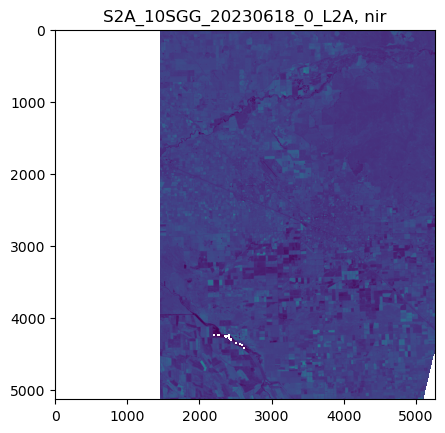

In [38]:
# Plot a single band 
plt.figure()
plt.imshow(stack.sel(band=band)[0])#.values[0:1500,0:1500])#,norm=colors.Normalize(0, 4000))
plt.title(f'{s2item.id}, {band}')

In [ ]:
stack.sel(band='red')

In [ ]:
makeScatterPlot('green','red')

## Load geojson points

In [ ]:
geojson_href = item.assets['labels'].href
print('href of the geojson file:', geojson_href)

In [ ]:
# Open asset (geojson format) and read all the coordinates within 
coordinates, luc = read_geojson_coordinates(geojson_href)
coordinates[:5], luc[:5]

In [ ]:
# Transofrm coordinates
epsg_s = '4326'
transformed_coords = transform_coordinates(coordinates, epsg_s, epsg_t)
transformed_coords[:5]

## Extract values of selected band(s) for each point in the geojson file


In [ ]:
# Define dictionary of other Common Band Names, for those that are missing in the metadata
other_cbn = {
    'B05': 'rededge70', 
    'B06': 'rededge74', 
    'B07': 'rededge78', 
    'B8A': 'nir08', 
    'B09': 'nir09'
}

In [ ]:
for band in list(s2item.assets.keys()): 
    b_metadata = s2item.assets[band].to_dict()
    if 'eo:bands' in b_metadata.keys() and len(b_metadata['eo:bands']) == 1:
        if 'common_name' in b_metadata['eo:bands'][0].keys(): 
            cbn = b_metadata['eo:bands'][0]['common_name']
        else: 
            # cbn does not exist in metadata - use dictionary of other_cbn
            cbn = other_cbn[b_metadata['eo:bands'][0]['name']]
    else: 
        print(f'{band} is not eo band, skipping.')
        continue

    if (df is not None) and (cbn in df.columns): 
        print(f'Band {cbn} exists already in the dataframe, skipping.')
        continue
    
    print('Band:', band)
    print(f'- Common Band Name: {cbn}')
    print(f'- Res: {b_metadata["gsd"]}m')
    print(f'- Center Wavelenght: {b_metadata["eo:bands"][0]["center_wavelength"]}')

    # Extract band
    b_href = s2item.assets[band].href
    print('- href:', b_href)

    # Get gdal object
    b_g = gdal.Open(b_href)
    
    # Extract pixel values
    pixel_values = extract_pixel_values(b_g, transformed_coords)
    # for (lon0, lat0), (lon1, lat1), value, lu in zip(coordinates[:5], transformed_coords[:5], pixel_values[:5], luc[:5]):
    #     print(f"Coords (Unprj): {np.round(lon0,3)}, {np.round(lat0,3)} - Coords (Prj): {lon1}, {lat1} - Pixel Value: {value} - LUC: {lu}")
    
    # Empty b_g
    b_g = None
    
    # Make or Append to Pandas dataframe
    data = {
        'long': [x[0] for x in transformed_coords], 
        'lat': [x[1] for x in transformed_coords], 
        'LUC': luc,
        cbn: pixel_values,
    }

    if df is None: 
        print('Creating Dataframe')
        # Create a DataFrame from the dictionary
        df = pd.DataFrame(data)
        df.index.name = 'Index'

    else: 
        print('Adding to existing Dataframe')

        # Create temp dataframe
        df2 = pd.DataFrame(data)
        df2.index.name = 'Index'

        # Assert the two dataframes have the same long and lat values
        assert df['long'].isin(df2['long']).value_counts().values[0] == len(pixel_values)
        assert df['lat'].isin(df2['lat']).value_counts().values[0] == len(pixel_values)

        # Merge temp dataframe with original dataframe, based on matching columns
        df = pd.merge(df, df2, on=['Index', 'long', 'lat', 'LUC'])   
        # Empty memory
        df2 = None

    display(df)
    print()

print('\n--- Complete Dataframe with all Sentinel-2 bands ---')
display(df)

## Add NDVI and NDWI bands

In [ ]:
# Add NDVI
assert 'nir' in df.columns and 'red' in df.columns
df['ndvi'] = ((df['nir'].astype(int) - df['red'].astype(int)) / (df['nir'].astype(int) + df['red'].astype(int)) * 10000).astype(int)
df

In [ ]:
# Add NDWI
# Formula for S2: NDWI = (NIR - MIR) / (NIR + MIR) using Sentinel-2 Band 8 (NIR) and Band 12 (MIR=SWIR for Sentinel2)
assert 'nir' in df.columns and 'swir16' in df.columns and 'swir22' in df.columns
df['ndwi1'] = ((df['nir'].astype(int) - df['swir16'].astype(int)) / (df['nir'].astype(int) + df['swir16'].astype(int)) * 10000).astype(int)
df['ndwi2'] = ((df['nir'].astype(int) - df['swir22'].astype(int)) / (df['nir'].astype(int) + df['swir22'].astype(int)) * 10000).astype(int)
df

## Add Water Label

In [ ]:
# Add Water label from the LUC value (LUC=6 is water)
df.loc[df['LUC'] == 6, 'water'] = 1
df.loc[df['LUC'] != 6, 'water'] = 0
df

## Show some statistics

In [ ]:
df.describe().T

## Export Dataframe to CSV

In [ ]:
# Export dataframe 
df.to_csv('df_extractedpixels.csv')

In [ ]:
print('END')

**Note**: If the ```epsg``` and ```resolution``` are not defined in all Items/Assets, they must be explicitly defined in the ```stackstac.stack()``` call. The ```resolution``` refers to the output resolution and must be set in the same unit as the ```epsg``` field ([stackstac documentation](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html)).